-This notebook is an example of how to properly set up the ScreenBeamProfileMeasurement Class:
    -Since ScreenBeamProfileMeasurement takes a screen object as a pydantic field to use for live images and this example is mean't to be 
done offline we subclass Screen and overwrite the the image property to a static 2d array. 
        -The array passed in this example is automatically

In [1]:
from lcls_tools.common.measurements.screen_beam_profile_measurement import ScreenBeamProfileMeasurement
from lcls_tools.common.data_analysis.projection_fit.projection_fit import ProjectionFit
from lcls_tools.common.data_analysis.projection_fit.gaussian_model import GaussianModel
from lcls_tools.common.image_processing.image_processing import ImageProcessor
from lcls_tools.common.image_processing.roi import ROI, RectangularROI, CircularROI
from lcls_tools.common.devices.device import Device, PVSet, ControlInformation, Metadata
from lcls_tools.common.devices.screen import ScreenControlInformation, ScreenPVSet, Screen
from matplotlib import pyplot as plt
from epics import PV, caget
import numpy as np
import h5py
import random

In [2]:
class ScreenTest(Screen):
    @property
    def image(self) -> np.ndarray:
        return self._image
    
    @image.setter
    def image(self,image):
        self._image = image

In [3]:
def create_test_image(size:tuple,center:list,radius:int):
    # make img that is a circle in the center of the image with known standard dev and mean. no imports, no calls to external or
    # internal files. 
    image = np.zeros(size)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            distance =  np.sqrt((x - center[0])**2 + (y - center[1])**2)
            if distance < radius:
                image[y,x]= 1
    return image

In [4]:
# creating projection fit class
gauss_model = GaussianModel()
projection_fit = ProjectionFit(model = gauss_model,visualize_fit = True, visualize_priors = True,use_priors =True)

In [5]:
# creating image processing class
# would be nice to have default way of finding the center of image
# also maybe have rectangularROI have default roi_type 'Rectangular', and change roi_type to roi
roi = RectangularROI(center =[400,400],xwidth=300,ywidth=300)
image_processor = ImageProcessor(roi = roi,visualize = True)

In [6]:
PV_strings = {
    'image': 'ArrayData',
    'n_bits': 'N_OF_BITS',
    'n_col': 'ArraySize1_RBV',
    'n_row': 'ArraySize0_RBV',
    'resolution': 'RESOLUTION'
}
metadata = {
        'area': 'TEST',
        'beam_path': ['SC_TEST'],
        'sum_l_meters': 99.99
        }
control_name =  "OTRS:TEST:650:"

In [7]:
# creating Screen Device
# inconsistent use of Controls_information and control_information between classes recommend change.
screen_pvs = ScreenPVSet(**PV_strings)
meta_data = Metadata(**metadata)
controls_information = ScreenControlInformation(control_name = control_name, PVs = screen_pvs )
screen_test = ScreenTest(controls_information = controls_information, metadata = meta_data)

In [8]:
test = ScreenBeamProfileMeasurement(name = control_name,device = screen_test, image_processor = image_processor, fitting_tool = projection_fit)

In [9]:
test.device.image = create_test_image((800,800),[400,400],50)

In [10]:

test.measure()

[{'raw_image': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'processed_image': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'amplitude_x': 99.0,
  'mean_x': 150.4932793340904,
  'sigma_x': 31.383576548600267,
  'offset_x': 0.99,
  'amplitude_y': 99.0,
  'mean_y': 150.4932793340904,
  'sigma_y': 31.383576548600267,
  'offset_y': 0.99}]

(<Figure size 640x480 with 1 Axes>, <Axes: >)

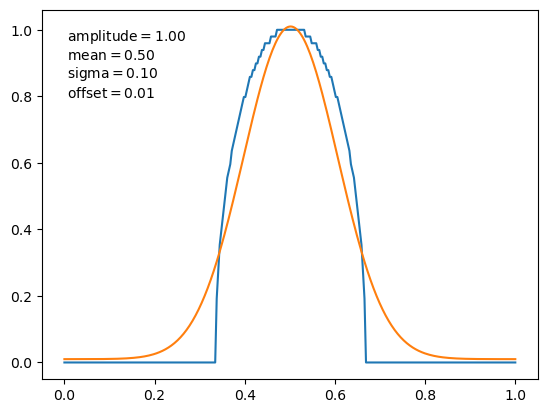

In [11]:
test.fitting_tool.plot_fit()